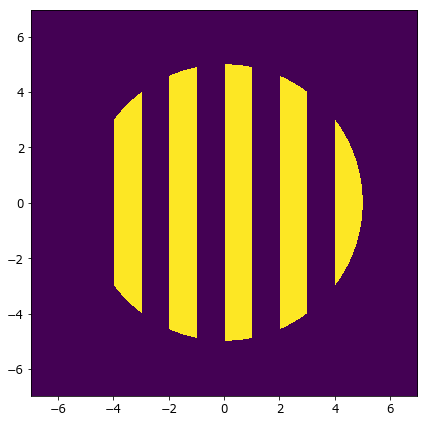

In [ ]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

def aberrate(aperture, N, input_grid, f=1):
    wf = Wavefront(aperture(input_grid))
    return aberrate_wf(N, wf, f)

def aberrate_wf(N, wf, f=1):
    shaped_field = wf.electric_field
    shaped_field.shape = (N, N)
    aslist = np.asarray(shaped_field).tolist()
    for rownum, row in enumerate(aslist):
        for colnum, el in enumerate(row):
            aslist[rownum][colnum] = el * np.sin(colnum * 2 * f * np.pi / N)
    wf.electric_field = Field(np.asarray(aslist).ravel(), wf.electric_field.grid)
    return wf

def estimate(EstimatorObject, images_list):
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    dummy = (I_a - I_a)
    I_x = I_x.ravel()
    I_y = I_y.ravel()
    dummy = dummy.ravel()
    res = Field([I_x, I_y, dummy], EstimatorObject.pupil_mask.grid)
    return res, I_x, I_y

def fullsim(N=128, padding=1):
    D_keck = 9.96
    keck_aperture = circular_aperture(D_keck)
    pupil_grid = make_pupil_grid(N, D_keck * padding)
    aberrated = aberrate(keck_aperture, N, pupil_grid, 5 * padding)
    imshow_field(keck_aperture(pupil_grid) * aberrated.phase)
    plt.show()
    sps = 40 * N//128 #sub-pupil size
    pupsep = 65/39.3
    outgrid_size = int(np.ceil(sps * (pupsep + 1)))
    keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
    pyramid_grid = make_pupil_grid(N, 3.6e-3)
    pyramid_output = keck_pyramid.forward(aberrated).intensity
    outgrid = np.zeros((N, N)).tolist()
    pyramid_output.shape = (outgrid_size, outgrid_size)
    buffer = (N - outgrid_size)//2
    for rownum, row in enumerate(pyramid_output.tolist()):
        for colnum, el in enumerate(row):
            outgrid[rownum+buffer][colnum+buffer] = el
    images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
    image = images.shaped
    sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
                  image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
    subimage_grid = make_pupil_grid(sps)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    pyramid_subgrid = make_pupil_grid(sps*2, (3.6e-3)*sps*2/N)
    keck_pyramid_estimator = PyramidWavefrontSensorEstimator(keck_aperture, pyramid_subgrid)
    aberratedslopes, x_slopes, y_slopes = estimate(keck_pyramid_estimator, sub_images)
    plt.subplot(2,2,1)
    imshow_field(x_slopes , vmax=0.005, vmin=-0.005)
    plt.colorbar()
    plt.subplot(2,2,2)
    imshow_field(y_slopes, vmax=0.005, vmin=-0.005)
    plt.subplot(2,2,4)
    imshow_field(aberratedslopes)
    plt.show()
    #with open('local_output.txt', 'a') as out:
        #out.write(str(N) + '\n' + str(padding) + '\n' + str(x_slopes.tolist()) + '\n' + str(y_slopes.tolist()) + '\n')

fullsim(8192, 1.4)
